In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


## Load the Data and View the columns
Begin to read the data into memory

In [2]:
train = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
test = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")

train.shape

(8693, 14)

In [3]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


<AxesSubplot:>

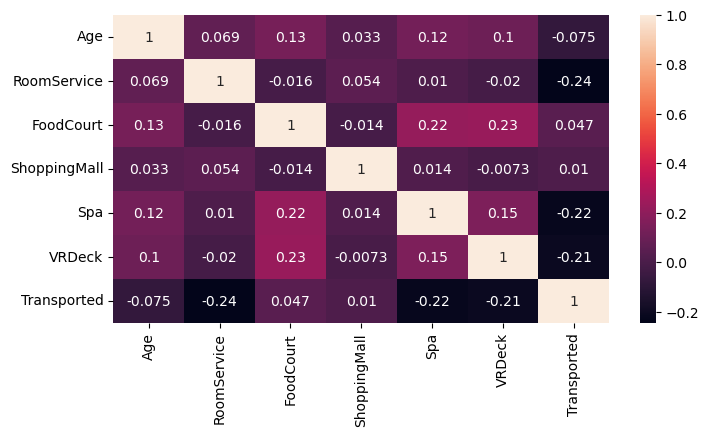

In [4]:
correlation = train.corr()
plt.figure(figsize=(8, 4))
sns.heatmap(correlation, annot=True) 

In [5]:
!pip install scikit-learn

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


## Preprocessing
We can drop the following columns. Cabin has over 6000 different labels and the passenger names are not relevant to the prediction.

In [6]:
train.drop(['Cabin', 'Name'], axis=1, inplace=True)
test.drop(['Cabin', 'Name'], axis=1, inplace=True)

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

def encode_data(data, predict_col=True):
    new_data = data.copy(deep=True)
    le = LabelEncoder()
    new_data['CryoSleep'] = le.fit_transform(new_data['CryoSleep'])
    new_data['VIP'] = le.fit_transform(new_data['VIP'])

    if predict_col:
        new_data['Transported'] = le.fit_transform(new_data['Transported'])

    # for column_idx in [1, 3]:
    ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [1, 3])], remainder='passthrough')
    new_data = np.array(ct.fit_transform(new_data))
    return pd.DataFrame(new_data).fillna(0)

# Classification

We'll use a simple RandomForestClassifier after we have preprocessed all of the data.

In [8]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()

train_new = encode_data(train)
x_train, y_train = train_new.iloc[:, :-1].astype(float), train_new.iloc[:, -1].astype(float)
x_test = encode_data(test, False).astype(float)

clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

In [9]:
test['Transported'] = y_pred
result = test[['PassengerId', 'Transported']].copy()

true_mask = result['Transported'] == 1.0

result.loc[true_mask, 'Transported'] = 'True'
result.loc[~true_mask, 'Transported'] = 'False'

result.to_csv("/kaggle/working/submission.csv", index=False, columns=['PassengerId', 'Transported'])